<br> </br>
<font color='darkred' size = 7.5> <center>  <b> Quantitative strategies on high-frequency data </b> </center> </font>
<font color='darkred' size = 5> <center>  2. Rolling analyses - part 1 </center> </font>
<br>
<font size = 5> <center> prof. Piotr Wójcik </center> </font>
<br> 
<font size = 5> <center>  academic year 2025/2026 </center> </font>

In [1]:
pip install bottleneck polars

   ---------------------------------------- 0.0/772.7 kB ? eta -:--:--
   ---------------------------------------- 772.7/772.7 kB 8.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/40.1 MB ? eta -:--:--
   --------- ------------------------------ 9.2/40.1 MB 43.5 MB/s eta 0:00:01
   ------------------------- -------------- 25.4/40.1 MB 61.2 MB/s eta 0:00:01
   ------------------------------------ --- 37.0/40.1 MB 59.6 MB/s eta 0:00:01
   ---------------------------------------- 40.1/40.1 MB 50.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [1]:
# we load the needed libraries

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import bottleneck as bt # for faster rolling calculations, written in C
import polars as pl  # for fast data manipulation
import timeit
import warnings
warnings.simplefilter(action="ignore", category=UserWarning)  # ignoring warnings of type UserWarning

In [2]:
# We import 1-minute quotations for US stocks downloaded from Alpha Vantage
# for the period 2025-01-01 do 2025-09-30

# downloaded from the Internet
data_url = "http://coin.wne.uw.edu.pl/pwojcik/hfd/US_stocks.csv"

dataUSA = pd.read_csv(data_url, 
                      # try to parse column "timestamp" as dates/datetimes
                      parse_dates = ["timestamp"], 
                      # use column "timestamp" as dataframe index
                      index_col = "timestamp")

dataUSA.head()

# open, high, low, close prices and volume for 14 companies:
# AAPL: Apple Co.
# META: Meta Platforms Inc.
# GOOGL: Alphabet Inc. (Google)
# KO: Coca-Cola
# PEP: Pepsi Co.
# MSFT: Microsoft Corp.
# GM: General Motors Co.
# GE: General Electric Co.
# AMZN: Amazon.com Inc.
# TSLA: Tesla Inc.
# WMT: Walmart
# NVDA: Nvidia
# MA: Mastercard
# V: Visa


,open_AAPL,high_AAPL,low_AAPL,close_AAPL,volume_AAPL,open_META,high_META,low_META,close_META,volume_META,...,open_MA,high_MA,low_MA,close_MA,volume_MA,open_V,high_V,low_V,close_V,volume_V
timestamp,,,,,,,,,,,,,,,,,,,,,
2025-01-02 09:31:00,248.3506,248.4105,247.4327,247.6023,1245220,588.7706,591.9455,588.1616,591.9156,209802.0,...,526.1993,526.1993,523.6041,524.7426,48309.0,316.7216,316.9708,316.1435,316.8013,122361.0
2025-01-02 09:32:00,247.6672,248.5202,246.7044,247.0636,463134,591.7708,591.9905,589.9987,591.6660,36859.0,...,525.0856,525.1453,523.6538,523.6538,7293.0,316.9658,317.0405,316.0440,316.4724,17787.0
2025-01-02 09:33:00,246.9938,247.8218,246.6595,246.6845,219248,591.8657,592.5845,591.1892,592.0054,47969.0,...,524.1311,524.5686,523.2262,524.1012,8385.0,316.0439,316.4724,315.7748,316.1336,22212.0
2025-01-02 09:34:00,246.6546,246.7581,245.7966,246.2006,399303,591.9455,591.9455,589.5294,589.5491,53483.0,...,524.1112,524.1510,523.5693,523.8328,10321.0,316.1236,316.3827,315.8346,315.9542,14137.0
2025-01-02 09:35:00,246.1757,246.3652,245.7267,245.7567,289896,589.7690,590.2483,588.8207,588.9803,31812.0,...,523.8328,524.8371,523.8228,523.8974,10893.0,315.9442,316.9708,315.9442,316.5821,33400.0


In [3]:
dataUSA.info()

# timestamp is not a column anymore, it is the index of the dataframe

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 72540 entries, 2025-01-02 09:31:00 to 2025-09-30 16:00:00
Data columns (total 70 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   open_AAPL     72540 non-null  float64
 1   high_AAPL     72540 non-null  float64
 2   low_AAPL      72540 non-null  float64
 3   close_AAPL    72540 non-null  float64
 4   volume_AAPL   72540 non-null  int64  
 5   open_META     72539 non-null  float64
 6   high_META     72539 non-null  float64
 7   low_META      72539 non-null  float64
 8   close_META    72539 non-null  float64
 9   volume_META   72539 non-null  float64
 10  open_GOOGL    72540 non-null  float64
 11  high_GOOGL    72540 non-null  float64
 12  low_GOOGL     72540 non-null  float64
 13  close_GOOGL   72540 non-null  float64
 14  volume_GOOGL  72540 non-null  int64  
 15  open_KO       71758 non-null  float64
 16  high_KO       71758 non-null  float64
 17  low_KO        71758 non-null  floa

In [4]:
# Let's create an object containing only closing prices
# (columns starting with "close_")

dataUSA_close = dataUSA.filter(like = "close_")

dataUSA_close.head()  

,close_AAPL,close_META,close_GOOGL,close_KO,close_PEP,close_MSFT,close_GM,close_GE,close_AMZN,close_TSLA,close_WMT,close_NVDA,close_MA,close_V
timestamp,,,,,,,,,,,,,,
2025-01-02 09:31:00,247.6023,591.9156,190.3931,61.6987,150.0814,423.5085,53.0975,168.4843,222.8448,389.6899,89.8008,136.3637,524.7426,316.8013
2025-01-02 09:32:00,247.0636,591.6660,189.6449,61.6198,149.8123,424.2551,52.5506,168.4194,223.6400,386.3200,89.9898,137.5285,523.6538,316.4724
2025-01-02 09:33:00,246.6845,592.0054,189.4254,61.6297,149.8123,422.8256,52.5605,168.0850,223.1635,385.6500,89.9102,137.3785,524.1012,316.1336
2025-01-02 09:34:00,246.2006,589.5491,188.6423,61.6100,149.9006,422.1233,52.4909,168.1349,221.6900,382.4400,89.8486,136.7164,523.8328,315.9542
2025-01-02 09:35:00,245.7567,588.9803,188.6373,61.6642,149.9251,422.1034,52.4154,168.4444,221.3900,381.8500,89.8853,136.5386,523.8974,316.5821


In [5]:
# let's check for missing data
# in individual columns

print(dataUSA_close.isna().sum())

close_AAPL        0
close_META        1
close_GOOGL       0
close_KO        782
close_PEP        28
close_MSFT        0
close_GM         93
close_GE        117
close_AMZN        0
close_TSLA        0
close_WMT        20
close_NVDA        0
close_MA       1465
close_V          68
dtype: int64


In [6]:
# fill missing data with the last non-missing value
# (forward fill method)

dataUSA_close.ffill(inplace = True)

C:\Users\hp\AppData\Local\Temp\ipykernel_8880\2420368710.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataUSA_close.ffill(inplace = True)


In [7]:
# based on closing prices
# we will calculate logarithmic rates of return for
# all series in basis points (bps) 1bps = 0.01% = 0.0001,
# to obtain basis points of return, multiply by 10,000

# Shift index by desired number of periods - can be positive or negative
dataUSA_r = np.log(dataUSA_close / dataUSA_close.shift(1)) * 10000

dataUSA_r.head()

,close_AAPL,close_META,close_GOOGL,close_KO,close_PEP,close_MSFT,close_GM,close_GE,close_AMZN,close_TSLA,close_WMT,close_NVDA,close_MA,close_V
timestamp,,,,,,,,,,,,,,
2025-01-02 09:31:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-02 09:32:00,-21.780366,-4.217707,-39.375061,-12.796135,-17.946364,17.613405,-103.533312,-3.852733,35.620511,-86.852531,21.024466,85.055874,-20.770777,-10.387295
2025-01-02 09:33:00,-15.356011,5.734700,-11.580967,1.606497,0.000000,-33.751244,1.883721,-19.874932,-21.329295,-17.358192,-8.849361,-10.912782,8.540165,-10.711249
2025-01-02 09:34:00,-19.635414,-41.577490,-41.426502,-3.197022,5.892306,-16.623494,-13.250658,2.968295,-66.246771,-83.584442,-6.853629,-48.311828,-5.122460,-5.676427
2025-01-02 09:35:00,-18.046287,-9.652709,-0.265055,8.793406,1.634283,-0.471437,-14.393800,18.390916,-13.541575,-15.439169,4.083815,-13.013487,1.233142,19.853413


In [8]:
# let's change the column names to make them appropriate
# (replace close_ with r_ )

dataUSA_r.columns = [col.replace("close_", "r_") for col in dataUSA_r.columns]

dataUSA_r.head()

,r_AAPL,r_META,r_GOOGL,r_KO,r_PEP,r_MSFT,r_GM,r_GE,r_AMZN,r_TSLA,r_WMT,r_NVDA,r_MA,r_V
timestamp,,,,,,,,,,,,,,
2025-01-02 09:31:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-02 09:32:00,-21.780366,-4.217707,-39.375061,-12.796135,-17.946364,17.613405,-103.533312,-3.852733,35.620511,-86.852531,21.024466,85.055874,-20.770777,-10.387295
2025-01-02 09:33:00,-15.356011,5.734700,-11.580967,1.606497,0.000000,-33.751244,1.883721,-19.874932,-21.329295,-17.358192,-8.849361,-10.912782,8.540165,-10.711249
2025-01-02 09:34:00,-19.635414,-41.577490,-41.426502,-3.197022,5.892306,-16.623494,-13.250658,2.968295,-66.246771,-83.584442,-6.853629,-48.311828,-5.122460,-5.676427
2025-01-02 09:35:00,-18.046287,-9.652709,-0.265055,8.793406,1.634283,-0.471437,-14.393800,18.390916,-13.541575,-15.439169,4.083815,-13.013487,1.233142,19.853413


## Sample analysis for Apple and Meta stocks

In [9]:
# Let's combine only closing prices and rates of return 
# for AAPL and META into one object

dataUSA_AAPL_META = pd.concat(
    [dataUSA_close[['close_AAPL', 'close_META']], 
     dataUSA_r[['r_AAPL', 'r_META']]],
    axis=1
)

dataUSA_AAPL_META.head()

,close_AAPL,close_META,r_AAPL,r_META
timestamp,,,,
2025-01-02 09:31:00,247.6023,591.9156,NaN,NaN
2025-01-02 09:32:00,247.0636,591.6660,-21.780366,-4.217707
2025-01-02 09:33:00,246.6845,592.0054,-15.356011,5.734700
2025-01-02 09:34:00,246.2006,589.5491,-19.635414,-41.577490
2025-01-02 09:35:00,245.7567,588.9803,-18.046287,-9.652709


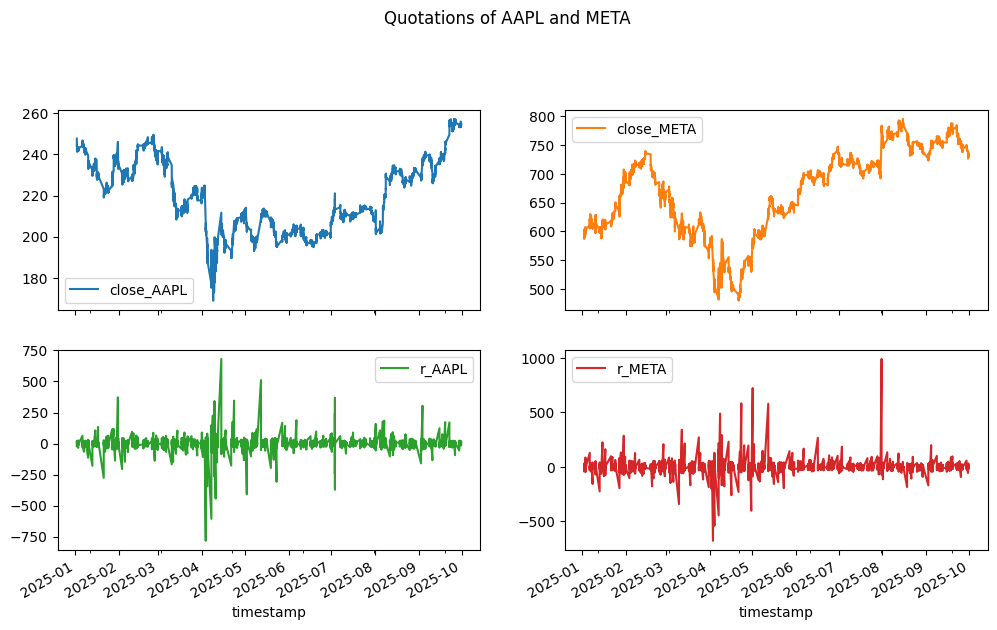

In [12]:
# Let's see a figure of all columns
# with closing prices and yields for AAPL and META
# on sublots

dataUSA_AAPL_META.plot(subplots = True,  
                  layout = (3, 2), 
                  title = "Quotations of AAPL and META",
                  figsize = (12, 10))
plt.show()

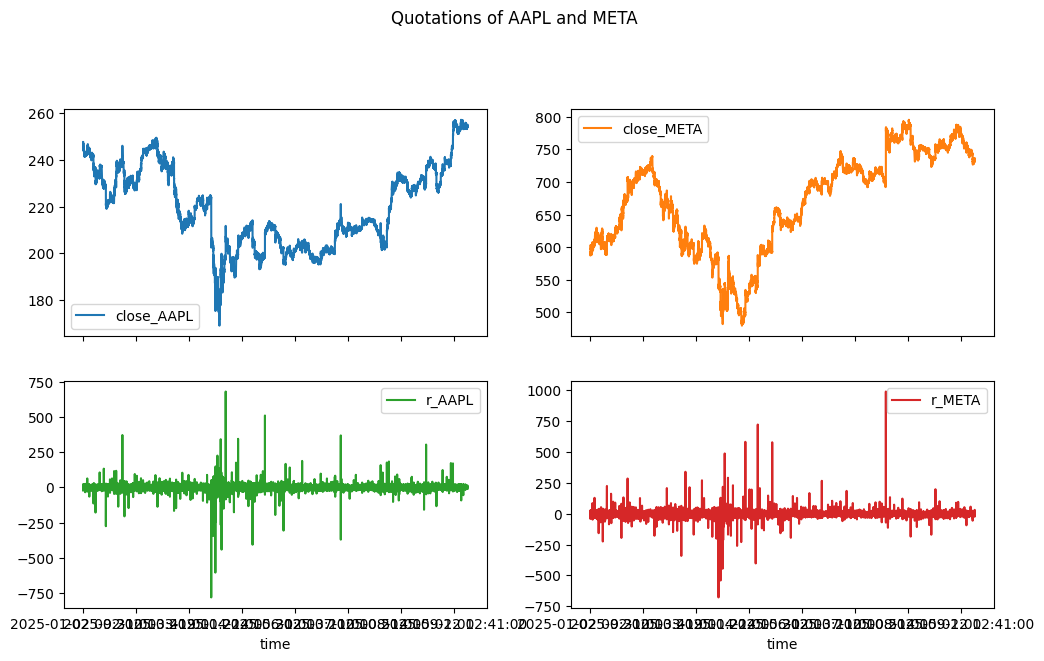

In [10]:
# We don't want to treat time as a continuous variable in the graph
# (because there are "holes" from 4:00 PM to 9:30 AM the next day)

# Let's convert the datetime index to a text index and pass it as the x-axis
dataUSA_AAPL_META_plot = dataUSA_AAPL_META.copy()
dataUSA_AAPL_META_plot['time'] = dataUSA_AAPL_META_plot.index.astype(str)

# We reset the index to make 'time' a column
dataUSA_AAPL_META_plot = dataUSA_AAPL_META_plot.reset_index(drop = True)

# Let's set time as the X-axis and draw the graphs
dataUSA_AAPL_META_plot.plot(
    x = 'time',
    subplots = True,
    layout = (3, 2),
    title = "Quotations of AAPL and META",
    figsize = (12, 10)
)

plt.show()

# In some periods, the closing price trends are similar.

# In turn, the rate of return chart shows outliers.
# (rates of return around 600-1000 bps, or 6-10% in one minute).

# These may be rates of return between 4:00 PM and 9:30 AM the following day.

## Rolling analyses

### Rolling volatility

In [11]:
# Let's check the standard deviation of AAPL's returns for the entire sample

AAPL_r_std = dataUSA_AAPL_META['r_AAPL'].std()

print("Standard deviation of AAPL returns:")
print(AAPL_r_std)

Standard deviation of AAPL returns:
11.490705901583814


In [12]:
# let's calculate the standard deviation for
# rolling intervals (in a 60-minute window)
dataUSA_AAPL_META['r_AAPL_rolling_std'] = dataUSA_AAPL_META['r_AAPL'].rolling(window = 60).std(ddof=1)

# ddof=1 to match the sample standard deviation (default in std())
# (N - ddof in the denominator)

In [13]:
# lets alternatively use the bottleneck library
# here we use move_std function
# but there are many others available in bottleneck
# e.g. move_mean, move_median, move_min, move_max, move_sum, etc.
# in addition, bottleneck functions deal with NaN values more flexibly
# e.g. we can define min_count - minimum number of observations in the window

# we define min_count = 60 to have at least 60 observations in the window
# (if less than 60 observations, result is NaN)

dataUSA_AAPL_META['r_AAPL_rolling_std_bt'] = bt.move_std(dataUSA_AAPL_META['r_AAPL'].values, 
                                                         window = 60, 
                                                         min_count = 60,
                                                         # here default is ddof = 0, so we set ddof = 1
                                                         ddof = 1)

In [14]:
# another alternative is to use polars library
# which requires more steps

# we convert pandas dataframe to polars dataframe
data_pl = pl.DataFrame(dataUSA_AAPL_META)
# then we calculate a rolling standard deviation
data_pl = data_pl.with_columns(
    pl.col('r_AAPL').rolling_std(window_size = 60, 
                                 ddof=1,
                                 # same as min_count in bottleneck
                                 min_samples = 60).alias('r_AAPL_rolling_std_pl')
)
# we convert the result back to a pandas dataframe column
dataUSA_AAPL_META['r_AAPL_rolling_std_pl'] = data_pl['r_AAPL_rolling_std_pl'].to_numpy()

In [15]:
# let's check the values ​​between the 55th and 65th minute (10:25 to 10:34)
# for all three methods

dataUSA_AAPL_META[['r_AAPL_rolling_std', 'r_AAPL_rolling_std_bt', 'r_AAPL_rolling_std_pl']].head(65).tail(10)

,r_AAPL_rolling_std,r_AAPL_rolling_std_bt,r_AAPL_rolling_std_pl
timestamp,,,
2025-01-02 10:26:00,NaN,NaN,NaN
2025-01-02 10:27:00,NaN,NaN,NaN
2025-01-02 10:28:00,NaN,NaN,NaN
2025-01-02 10:29:00,NaN,NaN,NaN
2025-01-02 10:30:00,NaN,NaN,NaN
2025-01-02 10:31:00,10.576821,10.576821,10.576821
2025-01-02 10:32:00,10.311058,10.311058,10.311058
2025-01-02 10:33:00,10.600031,10.600031,10.600031
2025-01-02 10:34:00,10.331219,10.331219,10.331219


In [16]:
# lets calculate the difference between each pair of methods
dataUSA_AAPL_META['rolling_std_diff_pandas_bt'] = dataUSA_AAPL_META['r_AAPL_rolling_std'] - dataUSA_AAPL_META['r_AAPL_rolling_std_bt']
dataUSA_AAPL_META['rolling_std_diff_pandas_pl'] = dataUSA_AAPL_META['r_AAPL_rolling_std'] - dataUSA_AAPL_META['r_AAPL_rolling_std_pl']
dataUSA_AAPL_META['rolling_std_diff_bt_pl'] = dataUSA_AAPL_META['r_AAPL_rolling_std_bt'] - dataUSA_AAPL_META['r_AAPL_rolling_std_pl']

# and check the summary statistics of the differences
print("Difference between pandas and bottleneck rolling std:")
print(dataUSA_AAPL_META['rolling_std_diff_pandas_bt'].describe())
print("Difference between pandas and polars rolling std:")
print(dataUSA_AAPL_META['rolling_std_diff_pandas_pl'].describe())
print("Difference between bottleneck and polars rolling std:")
print(dataUSA_AAPL_META['rolling_std_diff_bt_pl'].describe())

# the differences resulting from different numerical precision
# in various programming languages (python and C) are negligible

# but we should be aware of them

Difference between pandas and bottleneck rolling std:
count    7.248000e+04
mean    -7.465039e-13
std      7.039472e-13
min     -3.561373e-12
25%     -1.324274e-12
50%     -6.927792e-13
75%     -3.197442e-14
max      3.028688e-13
Name: rolling_std_diff_pandas_bt, dtype: float64
Difference between pandas and polars rolling std:
count    7.248000e+04
mean    -2.566319e-13
std      2.573712e-13
min     -1.391331e-12
25%     -4.298784e-13
50%     -1.847411e-13
75%     -3.019807e-14
max      3.286260e-14
Name: rolling_std_diff_pandas_pl, dtype: float64
Difference between bottleneck and polars rolling std:
count    7.248000e+04
mean     4.898720e-13
std      4.890711e-13
min     -3.144152e-13
25%      1.243450e-14
50%      4.520828e-13
75%      8.801848e-13
max      2.175149e-12
Name: rolling_std_diff_bt_pl, dtype: float64


In [17]:
# simple experiment to compare performance of these methods

# we create a large random array (1 million observations)
x = np.random.randn(1_000_000).astype('float64')
s = pd.Series(x)

# define functions to be tested
def pandas_std():
    return s.rolling(60).std(ddof=1)

def bottleneck_std():
    import bottleneck as bn
    return bn.move_std(x, window=60, min_count=60, ddof=1)

def polars_std():
    import polars as pl
    data_pl = pl.DataFrame({'x': x})
    data_pl = data_pl.with_columns(
        pl.col('x').rolling_std(window_size=60, min_samples=60).alias('x_rolling_std')
    )
    return data_pl['x_rolling_std'].to_numpy()

# benchmarking function
def bench(fn, repeats=50, number=1):
    times = timeit.repeat(fn, 
                          # number of times the experiment is repeated
                          repeat = repeats, 
                          # number of executions in each experiment
                          # if the function is very fast, we can increase this number
                          # to get more accurate results
                          number=number) 
    # calculate and return the median time
    return np.median(times)

for name, fn in {
    "pandas": pandas_std,
    "bottleneck": bottleneck_std,
    "polars": polars_std,
}.items():
    print(f"{name:>10}: {bench(fn)*1000:.1f} ms (median)")

# you can clearly see that the bottleneck method is the fastest here

    pandas: 31.6 ms (median)
bottleneck: 3.4 ms (median)
    polars: 18.8 ms (median)


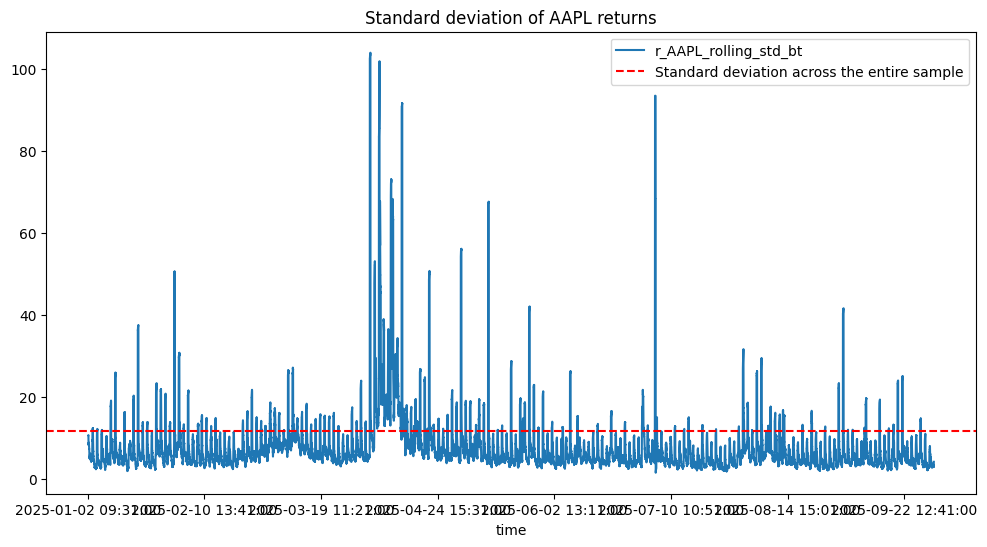

In [18]:
# Let's convert the datetime index to text and pass it as x-axis
dataUSA_AAPL_META_plot = dataUSA_AAPL_META.copy()
dataUSA_AAPL_META_plot['time'] = dataUSA_AAPL_META_plot.index.astype(str)

# We reset the index to make 'time' a column
dataUSA_AAPL_META_plot = dataUSA_AAPL_META_plot.reset_index(drop = True)

# plot the figure of 'r_AAPL_rolling_std_bt'

dataUSA_AAPL_META_plot.plot(
    x = 'time',
    y = 'r_AAPL_rolling_std_bt',
    title = "Standard deviation of AAPL returns",
    figsize = (12, 6)
)
# let's add a reference line at the standard deviation level
# AAPL_r_std
plt.axhline(y = AAPL_r_std, 
            color = 'r',
            linestyle = '--', 
            label = 'Standard deviation across the entire sample')
plt.legend()    

plt.show()
# volatility was lower than average for most of the period

###  Rolling correlation

In [19]:
# AAPL and META closing price correlation in the entire sample

correlation_p = dataUSA_AAPL_META['close_AAPL'].corr(dataUSA_AAPL_META['close_META'])

print("AAPL and META closing price correlation:")
print(correlation_p)

AAPL and META closing price correlation:
0.4269969800554541


In [20]:
# correlation of AAPL and META returns in the entire sample
correlation_r = dataUSA_AAPL_META['r_AAPL'].corr(dataUSA_AAPL_META['r_META'])
print("AAPL and META returns correlation:")
print(correlation_r)

# even slightly higher than for the closing prices - which is not typical

AAPL and META returns correlation:
0.4705840262426656


In [21]:
# rolling analysis of price correlations in a 2-hour (120-minute) timeframe

dataUSA_AAPL_META['rollcorr120_close_AAPL_META'] = dataUSA_AAPL_META['close_AAPL'].rolling(window=120).corr(dataUSA_AAPL_META['close_META'])

In [22]:
# there is no move_corr function in the bottleneck library
# but we can use polars for this purpose

# conversion pandas -> polars
data_pl = pl.from_pandas(dataUSA_AAPL_META)

# rolling correlation in polars
data_pl = data_pl.with_columns(
    pl.rolling_corr(
        pl.col("close_AAPL"),
        pl.col("close_META"),
        window_size = 120,
        min_samples = 120,    # in older versions: min_periods
        ddof = 1
    ).alias("rollcorr120_close_AAPL_META_pl")
)

# conversion of result back to Pandas
dataUSA_AAPL_META["rollcorr120_close_AAPL_META_pl"] = (
    data_pl["rollcorr120_close_AAPL_META_pl"].to_numpy()
)

In [23]:
# lets compare the results of both methods
# by calculating the difference

dataUSA_AAPL_META['rollcorr120_diff'] = dataUSA_AAPL_META['rollcorr120_close_AAPL_META'] - dataUSA_AAPL_META['rollcorr120_close_AAPL_META_pl']

print("Difference between pandas and polars rolling correlation:")
print(dataUSA_AAPL_META['rollcorr120_diff'].describe())

# again, the differences are negligible,
# i.e. we may round the resulting correlations
# to a few decimal places

Difference between pandas and polars rolling correlation:
count    7.242100e+04
mean     6.059854e-12
std      6.868779e-11
min     -1.742009e-09
25%      0.000000e+00
50%      0.000000e+00
75%      4.875350e-12
max      1.386280e-09
Name: rollcorr120_diff, dtype: float64


In [24]:
# lets compare the execution time of both methods

# we create two large random arrays (1 million observations)
x = np.random.randn(1_000_000).astype('float64')
y = np.random.randn(1_000_000).astype('float64')
s_x = pd.Series(x)
s_y = pd.Series(y)

# define functions to be tested
def pandas_corr():
    return s_x.rolling(120).corr(s_y)

def polars_corr():
    import polars as pl
    data_pl = pl.DataFrame({'x': x, 'y': y})
    data_pl = data_pl.with_columns(
        pl.rolling_corr(
            pl.col("x"),
            pl.col("y"),
            window_size = 120,
            min_samples = 120,
            ddof = 1
        ).alias("x_y_rolling_corr")
    )
    return data_pl['x_y_rolling_corr'].to_numpy()

# benchmarking function
def bench(fn, repeats=50, number=1):
    times = timeit.repeat(fn, 
                          # number of times the experiment is repeated
                          repeat = repeats, 
                          # number of executions in each experiment
                          # if the function is very fast, we can increase this number
                          # to get more accurate results
                          number=number) 
    # calculate and return the median time
    return np.median(times)

# and run the benchmark 50 times for each method
for name, fn in {
    "pandas": pandas_corr,
    "polars": polars_corr,
}.items():
    print(f"{name:>10}: {bench(fn)*1000:.1f} ms (median)")

# here polars is significantly faster than pandas
# but its syntax is more complex

    pandas: 175.3 ms (median)
    polars: 85.5 ms (median)


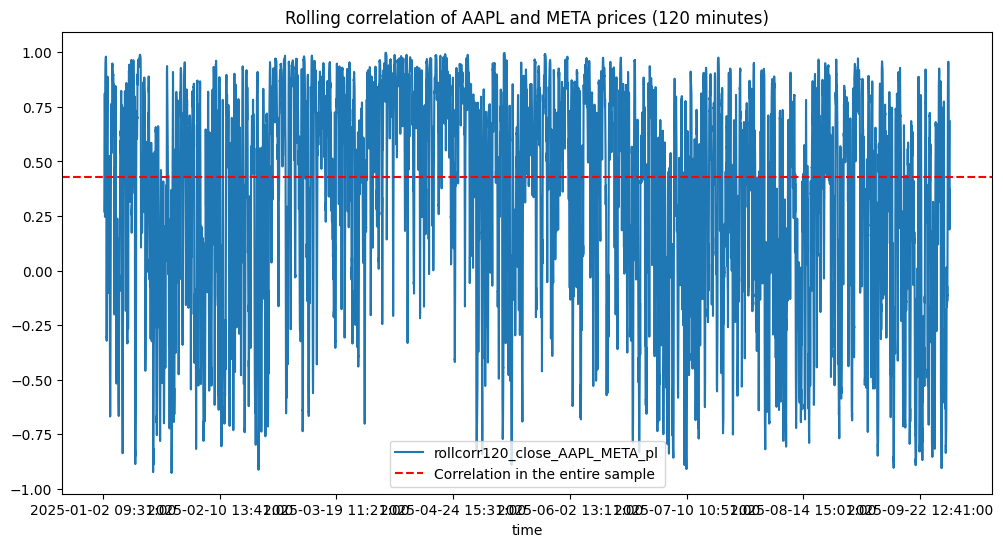

In [25]:
# Let's see how correlation changes over time

# Let's convert the datetime index to a text index and pass it as the x-axis
dataUSA_AAPL_META_plot = dataUSA_AAPL_META.copy()
dataUSA_AAPL_META_plot['time'] = dataUSA_AAPL_META_plot.index.astype(str)

# Reset the index so that 'time' is a column
dataUSA_AAPL_META_plot = dataUSA_AAPL_META_plot.reset_index(drop = True)

# Let's draw the 'rollcorr120_close_AAPL_META' graph
dataUSA_AAPL_META_plot.plot(
    x = 'time',
    y = 'rollcorr120_close_AAPL_META_pl',
    title = "Rolling correlation of AAPL and META prices (120 minutes)",
    figsize = (12, 6)
)

# let's add a reference line at the correlation level in the entire sample
plt.axhline(y = correlation_p,
            color = 'r',
            linestyle = '--',
            label = 'Correlation in the entire sample')

plt.legend()
plt.show()

In [26]:
# let's save the dataUSA_AAPL_META to the pickle file
# for further analysis

dataUSA_AAPL_META.to_pickle("dataUSA_AAPL_META.pkl")

# Exercises 2

Perform a similar analysis for **two other symbols**

# Exercise 2.1

* Create a separate data set with the necessary variables (closing prices and rates of return). 
* Plot graphs of the individual series.

In [28]:
dataUSA_KO_PEP = pd.concat(
    [dataUSA_close[['close_KO', 'close_PEP']], 
     dataUSA_r[['r_KO', 'r_PEP']]],
    axis=1
)

dataUSA_KO_PEP.head()

,close_KO,close_PEP,r_KO,r_PEP
timestamp,,,,
2025-01-02 09:31:00,61.6987,150.0814,NaN,NaN
2025-01-02 09:32:00,61.6198,149.8123,-12.796135,-17.946364
2025-01-02 09:33:00,61.6297,149.8123,1.606497,0.000000
2025-01-02 09:34:00,61.6100,149.9006,-3.197022,5.892306
2025-01-02 09:35:00,61.6642,149.9251,8.793406,1.634283


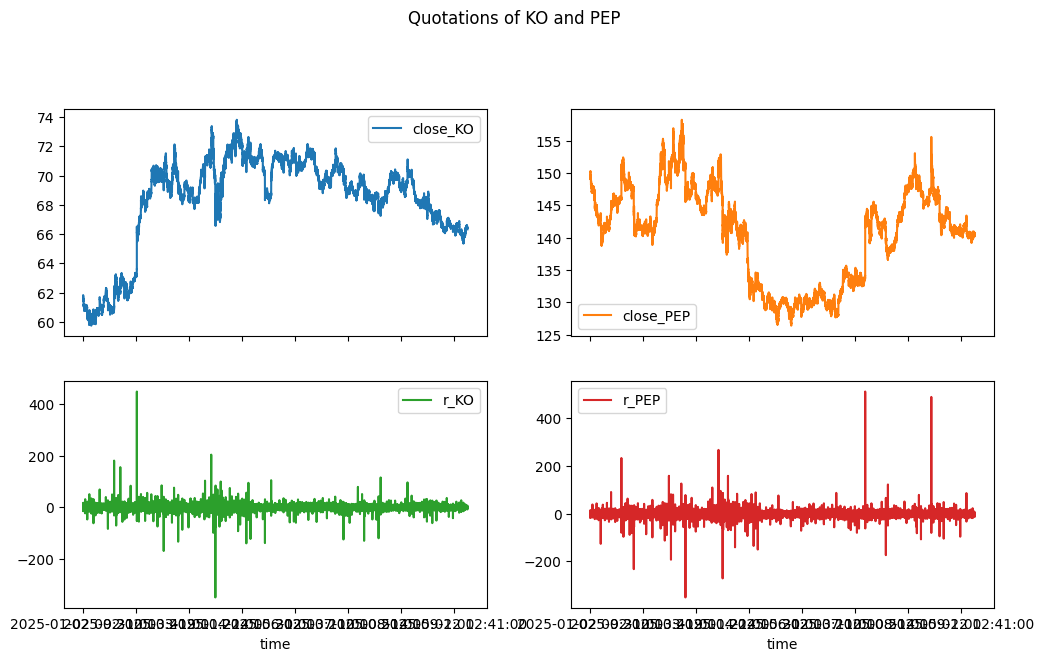

In [ ]:
dataUSA_KO_PEP_plot = dataUSA_KO_PEP.copy()
dataUSA_KO_PEP_plot['time'] = dataUSA_KO_PEP_plot.index.astype(str)

# We reset the index to make 'time' a column
dataUSA_KO_PEP_plot = dataUSA_KO_PEP_plot.reset_index(drop = True)

# Let's set time as the X-axis and draw the graphs
dataUSA_KO_PEP_plot.plot(
    x = 'time',
    subplots = True,
    layout = (3, 2),
    title = "Quotations of KO and PEP",
    figsize = (12, 10)
)

plt.show()

# The closing prices of pep is apparently higher than those of KO.

# In some periods, the closing price trends are similar.


# Exercise 2.2

Calculate and plot the standard deviation in a 150-minute rolling window for the **difference** between the rates of return of the selected assets (r1-r2).

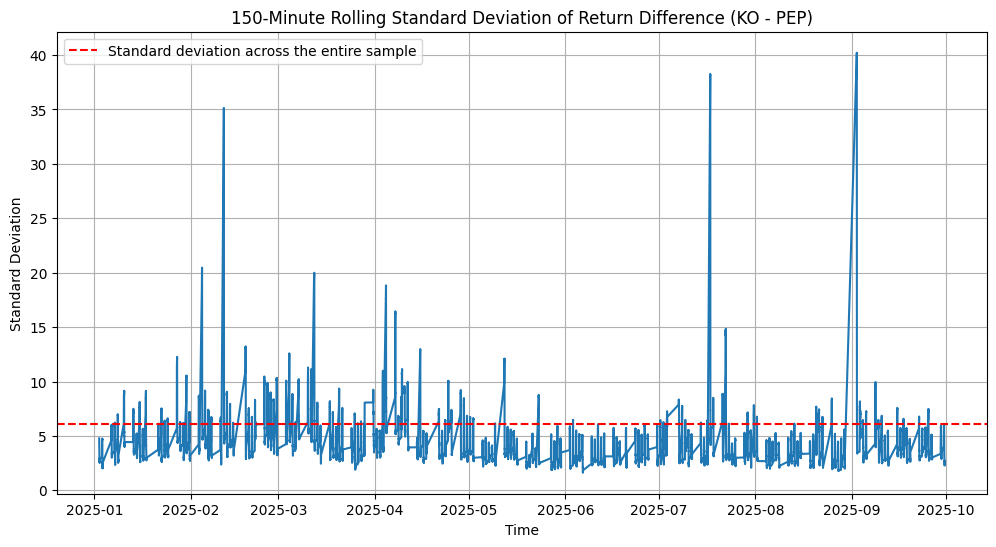

In [35]:
dataUSA_KO_PEP['r_diff'] = dataUSA_KO_PEP['r_KO'] - dataUSA_KO_PEP['r_PEP']
dataUSA_KO_PEP['r_diff_rolling_std_bt'] = bt.move_std(dataUSA_KO_PEP['r_diff'].values, 
                                                         window = 150, 
                                                         min_count = 150,
                                                         ddof = 1)
r_diff_std = dataUSA_KO_PEP['r_diff'].std()

plt.figure(figsize=(12, 6))
plt.plot(dataUSA_KO_PEP.index, dataUSA_KO_PEP['r_diff_rolling_std_bt'])
plt.title('150-Minute Rolling Standard Deviation of Return Difference (KO - PEP)')
plt.xlabel('Time')
plt.ylabel('Standard Deviation')
plt.axhline(y = r_diff_std, 
            color = 'r',
            linestyle = '--', 
            label = 'Standard deviation across the entire sample')
plt.grid(True)
plt.legend() 
plt.show()

# Exercise 2.3

Plot the change in the correlation coefficient between rates of return for a moving window of 90 minutes.

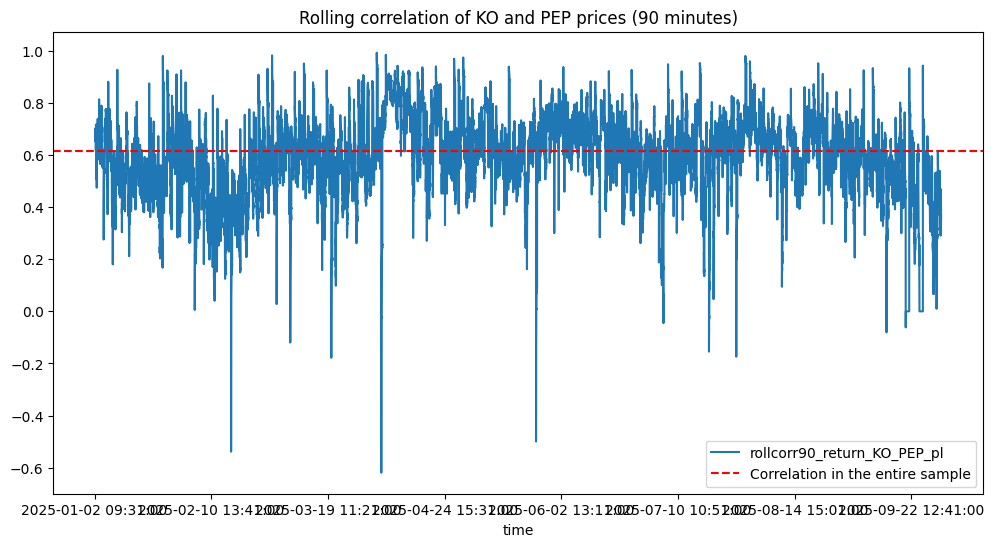

In [37]:
data_KO_PEP_pl = pl.from_pandas(dataUSA_KO_PEP)
correlation_KO_PEP_p = dataUSA_KO_PEP['r_KO'].corr(dataUSA_KO_PEP['r_PEP'])


# rolling correlation in polars
data_KO_PEP_pl= data_KO_PEP_pl.with_columns(
    pl.rolling_corr(
        pl.col("r_KO"),
        pl.col("r_PEP"),
        window_size = 90,
        min_samples = 90,    # in older versions: min_periods
        ddof = 1
    ).alias("rollcorr90_return_KO_PEP_pl")
)

# conversion of result back to Pandas
dataUSA_KO_PEP["rollcorr90_return_KO_PEP_pl"] = (
    data_KO_PEP_pl["rollcorr90_return_KO_PEP_pl"].to_numpy()
)

dataUSA_KO_PEP_plot = dataUSA_KO_PEP.copy()
dataUSA_KO_PEP_plot['time'] = dataUSA_KO_PEP_plot.index.astype(str)

# Reset the index so that 'time' is a column
dataUSA_KO_PEP_plot = dataUSA_KO_PEP_plot.reset_index(drop = True)

dataUSA_KO_PEP_plot.plot(
    x = 'time',
    y = 'rollcorr90_return_KO_PEP_pl',
    title = "Rolling correlation of KO and PEP prices (90 minutes)",
    figsize = (12, 6)
)

# let's add a reference line at the correlation level in the entire sample
plt.axhline(y = correlation_KO_PEP_p,
            color = 'r',
            linestyle = '--',
            label = 'Correlation in the entire sample')

plt.legend()
plt.show()

# Exercise 2.4

Save the dataset to the 'outputs' folder for further analysis.

In [38]:
dataUSA_KO_PEP.to_pickle("dataUSA_KO_PEP.pkl")